# 6. Modeling - Polynomials & PCA
---

### Library and Data Import

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns

import pickle

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
all_seasons = pd.read_csv('../data/batters_all_seasons_custom.csv')

### Polynomial Transformations

In [3]:
X = all_seasons.drop(columns=['Name', 'Tm', 'G',
                              'playerId', 'CS', 'SB',
                              'next_game_hit'])
y = all_seasons['next_game_hit']

In [4]:
poly = PolynomialFeatures(include_bias=False)

In [5]:
X_poly = poly.fit_transform(X)

In [7]:
len(poly.get_feature_names(X.columns))

1325

### Train Test Split / Scaling

In [9]:
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names(X.columns))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_poly_df, y, shuffle=False)

In [13]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Instantiating & Fitting the Model

In [15]:
lr = LogisticRegression()

In [16]:
lr.fit(X_train_sc, y_train)

/Users/BK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
# with open('../models/poly_logreg.pkl', 'wb') as f:
#     pickle.dump(lr, f)

### Model Evaluation

In [18]:
lr.score(X_train_sc, y_train)

0.6220047558075728

In [19]:
lr.score(X_test_sc, y_test)

0.6059386622766905

In [20]:
poly_pred_proba = [i[1] for i in lr.predict_proba(X_test_sc)]

poly_pred_df = pd.DataFrame({'true_values': y_test,
                           'pred_probs':poly_pred_proba})

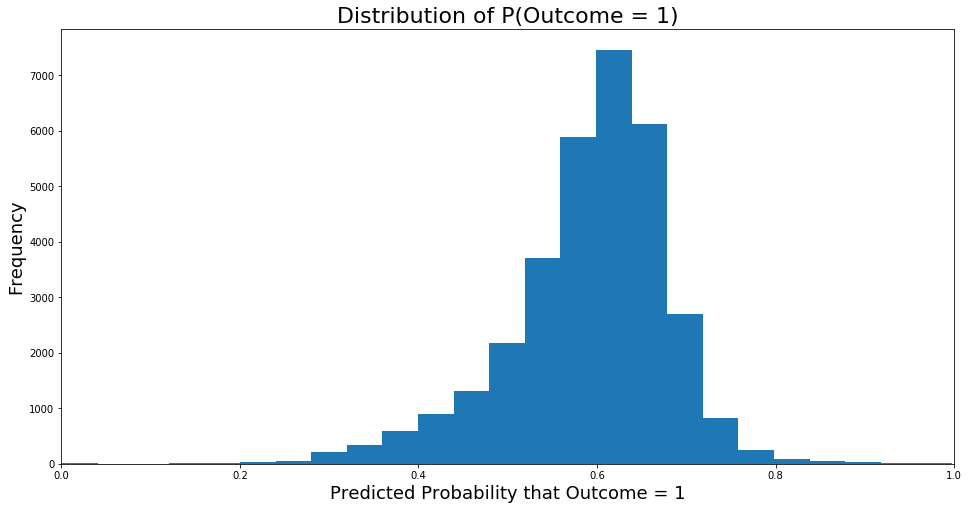

In [21]:
plt.figure(figsize = (16,8))

plt.hist(poly_pred_df['pred_probs'], bins=25)

plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)
plt.xlim(0,1);

In [22]:
poly_preds = lr.predict(X_test_sc)

In [23]:
def score_model(actuals, predictions):
    tn, fp, fn, tp = confusion_matrix(actuals, predictions).ravel()
    print(f'T Pos: {tp},   F Pos: {fp}')
    print(f'F Neg: {fn},   T Neg: {tn}')
    print(f'Accuracy: {(tp+tn)/len(predictions)}')
    print(f'Precision: {tp/(tp+fp)}')

In [24]:
score_model(y_test, poly_preds)

T Pos: 17387,   F Pos: 10940
F Neg: 1986,   T Neg: 2489
Accuracy: 0.6059386622766905
Precision: 0.6137960249938221


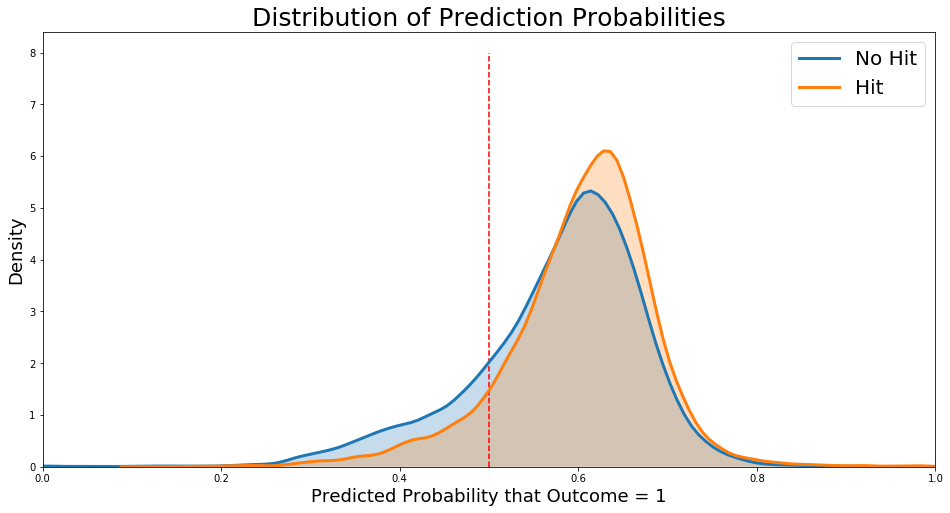

In [25]:
plt.figure(figsize = (16,8))

plt.vlines(x=0.5,
           ymin = 0,
           ymax = 8,
           color='r',
           linestyle = '--')

sns.distplot(poly_pred_df[poly_pred_df['true_values'] == 0]['pred_probs'],
             hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3},
             label='No Hit')
sns.distplot(poly_pred_df[poly_pred_df['true_values'] == 1]['pred_probs'],
             hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3},
             label='Hit')

plt.title('Distribution of Prediction Probabilities', fontsize=25)
plt.ylabel('Density', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)
plt.xlim(0,1)

plt.legend(fontsize=20);

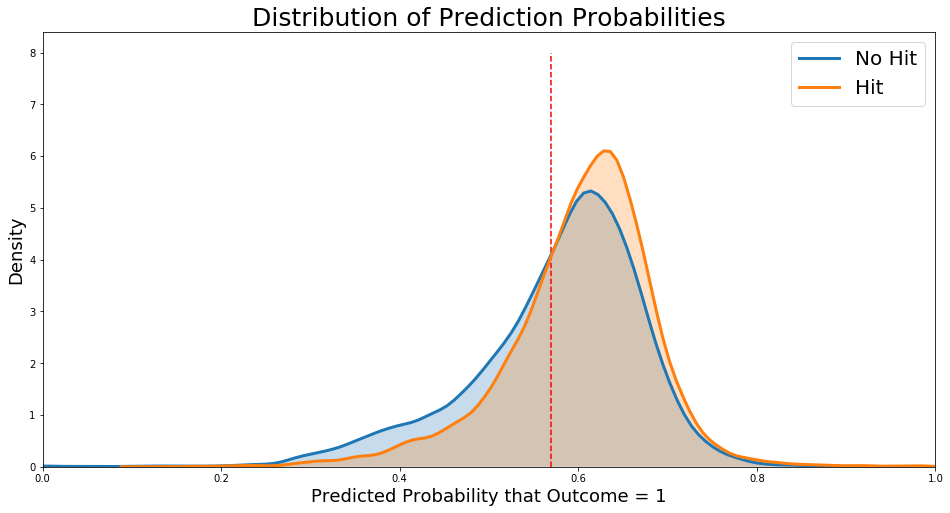

In [28]:
plt.figure(figsize = (16,8))

plt.vlines(x=0.57,
           ymin = 0,
           ymax = 8,
           color='r',
           linestyle = '--')

sns.distplot(poly_pred_df[poly_pred_df['true_values'] == 0]['pred_probs'],
             hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3},
             label='No Hit')
sns.distplot(poly_pred_df[poly_pred_df['true_values'] == 1]['pred_probs'],
             hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3},
             label='Hit')

plt.title('Distribution of Prediction Probabilities', fontsize=25)
plt.ylabel('Density', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)
plt.xlim(0,1)

plt.legend(fontsize=20);

In [59]:
lr_preds57 = (lr.predict_proba(X_test_sc)[:,1] >= 0.9455).astype(bool)

In [60]:
score_model(y_test, lr_preds57)

T Pos: 19,   F Pos: 0
F Neg: 19354,   T Neg: 13429
Accuracy: 0.4099750015242973
Precision: 1.0


In [75]:
neg_preds = (lr.predict_proba(X_test_sc)[:,1] <= 0.11).astype(bool)

In [76]:
score_model(y_test, neg_preds)

T Pos: 0,   F Pos: 15
F Neg: 19373,   T Neg: 13414
Accuracy: 0.4089384793610146
Precision: 0.0


In [77]:
len(y_test)

32802

### Instantiating & Fitting Principal Component Analysis

In [81]:
pca = PCA()

In [82]:
pca.fit(X_train_sc)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [83]:
z_train = pca.transform(X_train_sc)

In [84]:
z_test = pca.transform(X_test_sc)

In [85]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

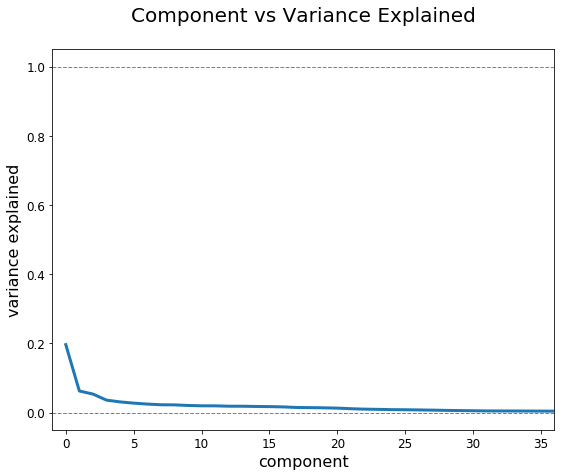

In [86]:
plt.figure(figsize=(9,7))

component_number = range(len(var_exp))
plt.plot(component_number, var_exp, lw=3)

plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

ax = plt.gca()
ax.set_xlim([-1,36])
ax.set_ylim([-0.05,1.05])

ax.set_ylabel('variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('Component vs Variance Explained\n', fontsize=20)

plt.show()

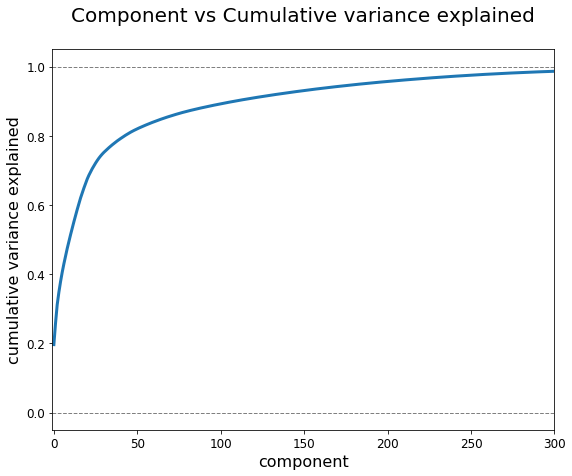

In [90]:
plt.figure(figsize=(9,7))

component_number = range(len(cum_var_exp))
plt.plot(component_number, cum_var_exp, lw=3)

plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

ax = plt.gca()
ax.set_xlim([-1,300])
ax.set_ylim([-0.05,1.05])

ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('Component vs Cumulative variance explained\n', fontsize=20)

plt.show()

### Re-instantiating & Re-fitting PCA, Model Evaluation

In [91]:
pca = PCA(n_components = 250)
pca.fit(X_train_sc)

PCA(copy=True, iterated_power='auto', n_components=250, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [92]:
lr_pca = LogisticRegression()

z_train = pca.transform(X_train_sc)
z_test = pca.transform(X_test_sc)

lr_pca.fit(z_train, y_train)

lr_pca.score(z_train, y_train)

/Users/BK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6168018210271732

In [94]:
lr_pca.score(z_test, y_test)

0.606700810926163

In [95]:
pca_preds = lr_pca.predict(z_test)

In [96]:
score_model(y_test, pca_preds)

T Pos: 17649,   F Pos: 11177
F Neg: 1724,   T Neg: 2252
Accuracy: 0.606700810926163
Precision: 0.6122597654894887


In [97]:
pca_pred_proba = [i[1] for i in lr_pca.predict_proba(z_test)]

pca_pred_df = pd.DataFrame({'true_values': y_test,
                           'pred_probs':pca_pred_proba})

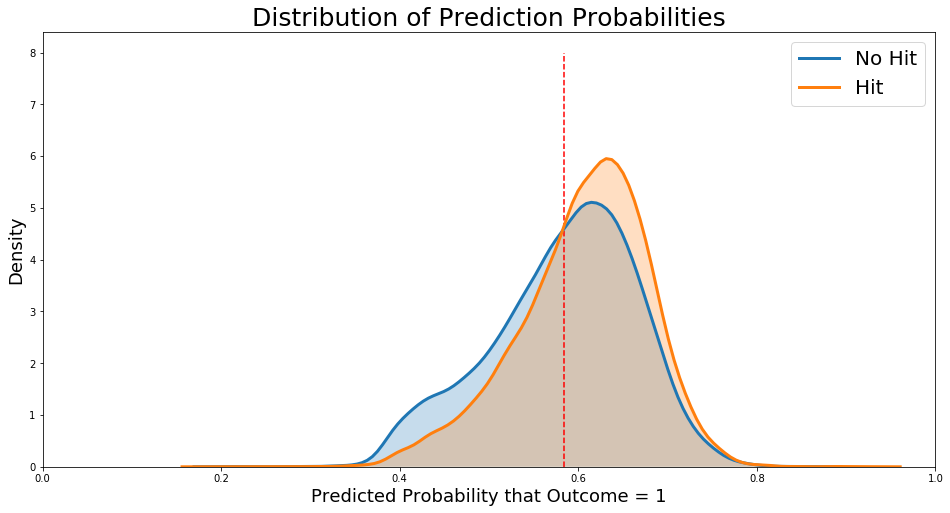

In [103]:
plt.figure(figsize = (16,8))

plt.vlines(x=0.5835,
           ymin = 0,
           ymax = 8,
           color='r',
           linestyle = '--')

sns.distplot(pca_pred_df[pca_pred_df['true_values'] == 0]['pred_probs'],
             hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3},
             label='No Hit')
sns.distplot(pca_pred_df[pca_pred_df['true_values'] == 1]['pred_probs'],
             hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3},
             label='Hit')

plt.title('Distribution of Prediction Probabilities', fontsize=25)
plt.ylabel('Density', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)
plt.xlim(0,1)

plt.legend(fontsize=20);

In [104]:
pca_preds5835 = (lr_pca.predict_proba(z_test)[:,1] >= 0.5835).astype(bool)

In [105]:
score_model(y_test, pca_preds5835)

T Pos: 12869,   F Pos: 7332
F Neg: 6504,   T Neg: 6097
Accuracy: 0.578196451435888
Precision: 0.6370476709073808


In [107]:
X_poly_df.head()

PA   AB    H   1B   2B   3B   HR    R  RBI   BB  ...  prev5_bippa^2  \
0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...           81.0   
1  5.0  4.0  1.0  0.0  0.0  0.0  1.0  1.0  2.0  1.0  ...          169.0   
2  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...           64.0   
3  4.0  3.0  2.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  ...          225.0   
4  4.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...          196.0   

   prev5_bippa hpa  prev5_bippa prev3_hpa  prev5_bippa prev5_hpa   hpa^2  \
0             2.25               2.000000               1.588235  0.0625   
1             2.60               2.000000               1.238095  0.0400   
2             0.00               2.666667               2.000000  0.0000   
3             7.50               2.307692               2.727273  0.2500   
4             0.00               2.545455               3.684211  0.0000   

   hpa prev3_hpa  hpa prev5_hpa  prev3_hpa^2  prev3_hpa prev5_hpa  prev5_hpa^2  
0       0.055556       0.044118     0.049383             0.039216     0.031142  
1       0.030769       0.019048     0.023669             0.014652     0.009070  
2       0.000000       0.000000     0.111111             0.083333     0.062500  
3       0.076923       0.090909     0.023669             0.027972     0.033058  
4       0.000000       0.000000     0.033058             0.047847     0.069252  

[5 rows x 1325 columns]

In [108]:
X_poly_df.to_csv('../data/batters_all_seasons_X_poly.csv')